<a href="https://colab.research.google.com/github/HarishBachu/Kidney_Cancer_Subtype_Classification/blob/main/RESNET50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pkbar

In [2]:
import torch
import torchvision as tv 
from torchvision import datasets, transforms
import torch.nn as nn 
from torch.nn import functional as F

import numpy as np 
from PIL import Image
from matplotlib import pyplot as plt 

import os
from tqdm import tqdm
import pkbar

In [3]:
train_dir = 'drive/MyDrive/IVP_Project_Sem6/Dataset/Training_images'
test_dir = 'drive/MyDrive/IVP_Project_Sem6/Dataset/Test_images'

In [4]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
batch_size = 32
classes = 5
input_shape = (3, 224, 224)

epochs = 50
# lr = 1e-5

In [7]:
train_transforms = transforms.Compose(
    [
     transforms.RandomRotation(30),
     transforms.RandomResizedCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor()
    ]
)

val_transforms = transforms.Compose(
    [
     transforms.CenterCrop(224),
     transforms.ToTensor()
    ]
)

test_transforms = transforms.Compose(
    [
     transforms.CenterCrop(224),
     transforms.ToTensor()
    ]
)

In [8]:
trainData = datasets.ImageFolder(train_dir, transform = train_transforms)
testData = datasets.ImageFolder(test_dir, transform = test_transforms)

l_data = len(trainData)

class_dict=trainData.class_to_idx
# print(class_dict)
class_labels = class_dict.values()
# print(class_labels)

train_split = int(0.8*l_data)
val_split = l_data - train_split

trainData, valData = torch.utils.data.random_split(trainData, [train_split, val_split])

trainLoader = torch.utils.data.DataLoader(trainData, batch_size = batch_size, shuffle = True)
valLoader = torch.utils.data.DataLoader(valData, batch_size = batch_size, shuffle = True)
testLoader = torch.utils.data.DataLoader(testData, batch_size = batch_size, shuffle = True)

In [9]:
def plot_random_sample(loader):
    iterate = iter(loader)
    iternext = next(iterate)
    img, lab = iternext
    # print(len(img))
    fig, ax = plt.subplots(5, 5, figsize = (20, 20), )
    for i in range(5):
        for j in range(5):
            ax[i][j].imshow(img[j + 5*i].permute(2, 1, 0))
            ax[i][j].set_title(lab[j + 5*i].item(), fontsize = 15)
    
    plt.show()

        

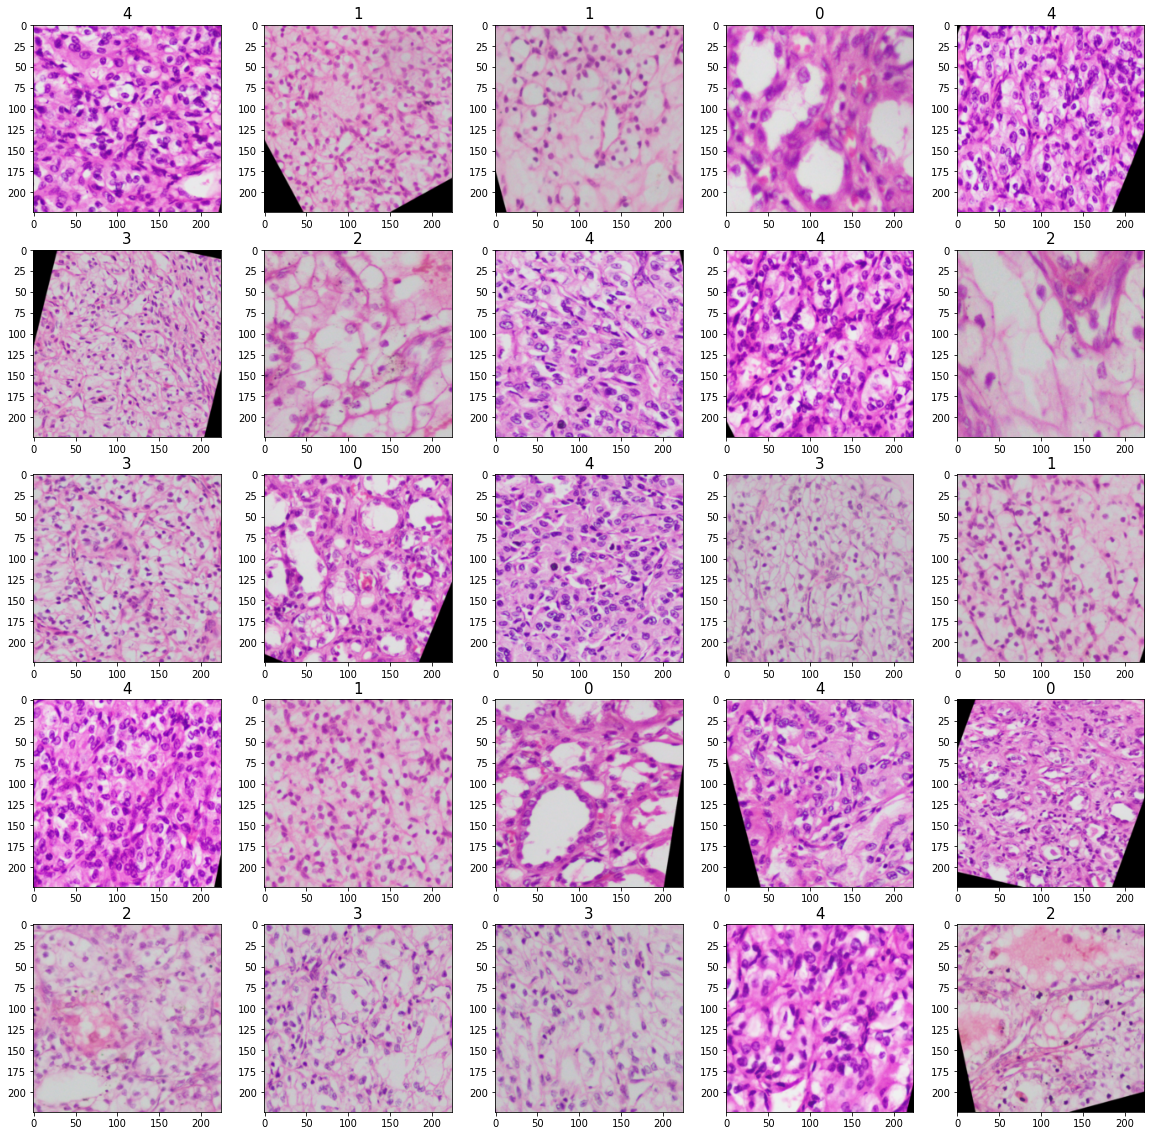

In [10]:
plot_random_sample(trainLoader)

In [11]:
class Res_Block(nn.Module):

    exp = 4

    def __init__(self, in_planes, out_planes, dims_change = None, stride = 1):
        super(Res_Block, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, out_planes, stride = 1, kernel_size = 1, padding = 0)
        self.bnorm1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, stride = stride, kernel_size = 3, padding = 1)
        self.bnorm2 = nn.BatchNorm2d(out_planes)
        self.conv3 = nn.Conv2d(out_planes, out_planes*self.exp, stride = 1, kernel_size = 1, padding = 0)
        self.bnorm3 = nn.BatchNorm2d(out_planes*self.exp)
        self.relu = nn.ReLU()

        self.dims_change = dims_change 

    def forward(self, x):

        residue = x
        x = self.conv1(x)
        x = self.relu(self.bnorm1(x))
        x = self.conv2(x)
        x = self.relu(self.bnorm2(x))
        x = self.conv3(x)
        x = self.bnorm3(x)

        if self.dims_change is not None:
            residue = self.dims_change(residue)

        x += residue
        return self.relu(x)
            

In [12]:
class ResNet50(nn.Module):

    def __init__(self, Res_Block, layers, channels, classes):
        super(ResNet50, self).__init__()

        self.in_planes = 64

        self.conv1 = nn.Conv2d(channels, 64, stride = 2, kernel_size = 7, padding = 3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.maxPool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.l1 = self._convBlock(Res_Block, layers[0], out_planes = 64, stride = 1)
        self.l2 = self._convBlock(Res_Block, layers[1], out_planes = 128, stride = 2)
        self.l3 = self._convBlock(Res_Block, layers[2], out_planes = 256, stride = 2)
        self.l4 = self._convBlock(Res_Block, layers[3], out_planes = 512, stride = 2)

        self.avgPool = nn.AdaptiveAvgPool2d((1, 1))
        self.dense = nn.Linear(512*4, classes)

        self.relu = nn.ReLU()

    def _convBlock(self, Res_Block, n_blocks, out_planes, stride):

        dims_change = None

        Layers = []

        if stride != 1 or self.in_planes != out_planes*4:
            dims_change = nn.Sequential(
                 nn.Conv2d(self.in_planes, out_planes*4, kernel_size = 1, stride = stride),
                 nn.BatchNorm2d(out_planes*4)
            )

        Layers.append(Res_Block(self.in_planes, out_planes, dims_change, stride))
        self.in_planes = out_planes * 4 

        for i in range(n_blocks - 1):
            Layers.append(Res_Block(self.in_planes, out_planes))

        return nn.Sequential(*Layers)

    def forward(self, x):

        x = nn.Sequential(
            self.conv1,
            self.bnorm1,
            self.relu,
            self.maxPool,
            self.l1, self.l2, self.l3, self.l4, 
            self.avgPool
        )(x)

        x = x.reshape(x.shape[0], -1)
        x = self.dense(x)
        return x


In [13]:
def createResNet(channels = 3, classes = classes):
    return ResNet50(Res_Block, layers = [3, 4, 6, 3], channels = channels, classes = classes)

In [18]:
model = createResNet()
model.to(device)

ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxPool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (l1): Sequential(
    (0): Res_Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dims_change): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

In [19]:
from torchsummary import summary

summary(model, input_size = input_shape, batch_size = batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,472
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]           4,160
       BatchNorm2d-6           [32, 64, 56, 56]             128
              ReLU-7           [32, 64, 56, 56]               0
            Conv2d-8           [32, 64, 56, 56]          36,928
       BatchNorm2d-9           [32, 64, 56, 56]             128
             ReLU-10           [32, 64, 56, 56]               0
           Conv2d-11          [32, 256, 56, 56]          16,640
      BatchNorm2d-12          [32, 256, 56, 56]             512
           Conv2d-13          [32, 256, 56, 56]          16,640
      BatchNorm2d-14          [32, 256,

In [20]:
def save_checkpoint(model, optimizer, to_file):
    checkpoint = {'state_dict' : model.state_dict(),
                  'optimizer_dict' : optimizer.state_dict}
    torch.save(checkpoint, to_file)

def load_checkpoint(model, optimizer, from_file):
    checkpoint = torch.load(from_file, map_location = torch.device(device))
    model.load_state_dict(checkpoint['state_dict'])
    # optimizer.load_state_dict(checkpoint['optimizer_dict'])
    return model

def accuracy(prediction, label):

    n_correct = 0
    n_samples = 0
    _, preds = prediction.max(1)
    n_correct += (preds == label).sum()
    n_samples = preds.size(0)

    return n_correct/n_samples

In [21]:
n_trainBatches = len(trainLoader)
n_valBatches = len(valLoader)
min_loss = np.inf

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

model_path = "/content/drive/MyDrive/IVP_Project_Sem6/Dataset/ResNet50_checkpoint.pth.tar"
for epoch in range(epochs):

    train_loss = []
    val_loss = []
    # train_acc = []
    # val_acc = []

    train_loop, val_loop = enumerate(trainLoader), enumerate(valLoader)

    # train_loop = tqdm(trainLoader, ascii = True, desc = "Epoch {}/{}".format(epoch+1, epochs), ncols = 100)
    # val_loop = tqdm(valLoader, ascii = True, desc = "Vaidation Epoch {}/{}".format(epoch+1, epochs), ncols = 100)
    
    train_bar = pkbar.Kbar(target = n_trainBatches, epoch = epoch, num_epochs = epochs)
    val_bar = pkbar.Kbar(target = n_valBatches, epoch = epoch, num_epochs = epochs)

    for idx, (data, label) in train_loop:

        model.train()
        data, label = data.to(device), label.to(device)

        prediction = model(data)

        t_loss = loss_fn(prediction, label)
        train_loss.append(t_loss.item())

        optimizer.zero_grad()
        t_loss.backward()

        optimizer.step()

        t_acc = accuracy(prediction, label)
        # train_acc.append(t_acc.item())

        train_bar.update(idx, values = [("loss", t_loss.item()), ("acc", t_acc.item())])
    train_bar.update(n_trainBatches, values = None)
    
    for idx, (val_data, val_label) in val_loop:

        val_data = val_data.to(device)
        val_label = val_label.to(device)
        model.eval()
        prediction = model(val_data)
        v_loss = loss_fn(prediction, val_label)
        val_loss.append(v_loss.item())
        v_acc = accuracy(prediction, val_label)
        # val_acc.append(v_acc.item())

        val_bar.update(idx, values = [("val_loss", v_loss.item()), ("val_acc", v_acc.item())])
        if np.mean(val_loss) < min_loss:
            min_loss = v_loss.item()
            print("Current Checkpoint Loss: {:.4f}".format(min_loss))
            print("Saving Model ...")
            save_checkpoint(model, optimizer, model_path)
            print("Model Saved at: {}".format(model_path))
    val_bar.update(n_valBatches, values = None)



Epoch: 1/50
Epoch: 1/50
0/2 [..............................] - ETA: 0s - val_loss: 0.0000e+00 - val_acc: 0.0000e+00Current Checkpoint Loss: 2.5294
Saving Model ...
Model Saved at: /content/drive/MyDrive/IVP_Project_Sem6/Dataset/ResNet50_checkpoint.pth.tar
1/2 [==============>...............] - ETA: 12s - val_loss: 2.3820 - val_acc: 0.3333       Current Checkpoint Loss: 2.3820
Saving Model ...
Model Saved at: /content/drive/MyDrive/IVP_Project_Sem6/Dataset/ResNet50_checkpoint.pth.tar
2/2 [==============================] - 14s 7s/step - val_loss: 2.3820 - val_acc: 0.3333
Epoch: 2/50
Epoch: 2/50
2/2 [==============================] - 12s 6s/step - val_loss: 5.9088 - val_acc: 0.3333
Epoch: 3/50
Epoch: 3/50
2/2 [==============================] - 12s 6s/step - val_loss: 4.7245 - val_acc: 0.0000e+00
Epoch: 4/50
Epoch: 4/50
2/2 [==============================] - 12s 6s/step - val_loss: 6.6930 - val_acc: 0.3333
Epoch: 5/50
Epoch: 5/50
2/2 [==============================] - 12s 6s/step - val_los

In [22]:
resnet50= load_checkpoint(model, optimizer, model_path)

In [23]:
def CONFUSION_MATRIX(y_true, y_pred, class_labels, order=False):
  
  num_classes= len(class_labels)
  num_examples= len(y_true)

  if order is False:
    new_labels= np.arange(num_classes)
    
    for i in range(num_examples):
      y_true[i].item= np.where(class_labels==y_true[i])[0]
      y_pred[i].item= np.where(class_labels==y_pred[i])[0]

  mat= np.zeros((num_classes,num_classes), dtype=np.int)
  
  for i in range(num_examples):
    true= np.uint8(y_true[i].item())
    pred= np.uint8(y_pred[i].item())

    mat[true,pred]+=1

  return mat


def acc_precision_recall_f1(confusion_matrix):

  num_classes= confusion_matrix.shape[0]
  precision=      np.zeros((num_classes,1), np.float64)
  recall=         np.zeros((num_classes,1), np.float64)
  true_positives= np.zeros((num_classes,1), np.float64)
  true_negatives= np.zeros((num_classes,1), np.float64)
  accuracy=       np.zeros((num_classes,1), np.float64)
  f1=             np.zeros((num_classes,1), np.float64)

  for i in range(num_classes):
    
    true_positives[i]= confusion_matrix[i,i]
    precision[i]= confusion_matrix[i,i]/np.sum(confusion_matrix[i])
    recall[i]= confusion_matrix[i,i]/np.sum(confusion_matrix[:,i])
    f1[i]= 2*precision[i]*recall[i]/(precision[i]+recall[i])
  

  for i in range(num_classes):
    true_negatives[i]=0
    for j in range(num_classes):
      for k in range(num_classes):
        if (j!=i) and (k!=i):
          true_negatives[i]+=confusion_matrix[j,k]

  accuracy= (true_positives+true_negatives)/np.sum(confusion_matrix)
  return accuracy, precision, recall, f1


def Final_Metrics(loader, model_a, class_labels):

    model_a.eval()
    size= len(class_labels)
    c_mat= np.zeros((size,size), dtype= np.int)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores= model_a(x)
            _, preds = scores.max(1)

            c_mat+= CONFUSION_MATRIX(y, preds, class_labels, order= True)
    
    accuracy, precision, recall, f1= acc_precision_recall_f1(c_mat)

    return c_mat, accuracy, precision, recall, f1

In [26]:
confusion_matrix, accuracy, precision, recall, f1= Final_Metrics(testLoader, resnet50, class_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


In [27]:
print('CONFUSION MATRIX:\n',confusion_matrix,'\n')

print("PRECISION:",precision)
print("RECALL:",recall)
print("F1 SCORE:",f1)
print("ACCURACY:",accuracy)

print("PRECISION:",np.mean(precision))
print("RECALL:",np.mean(recall))
print("F1 SCORE:",np.mean(f1))
print("ACCURACY:",np.mean(accuracy))

CONFUSION MATRIX:
 [[ 0  2  8 10  0]
 [ 0  1  9  7  3]
 [ 0  0 20  0  0]
 [ 0  4  5 17  0]
 [ 1  0  1  1 17]] 

PRECISION: [[0.        ]
 [0.05      ]
 [1.        ]
 [0.65384615]
 [0.85      ]]
RECALL: [[0.        ]
 [0.14285714]
 [0.46511628]
 [0.48571429]
 [0.85      ]]
F1 SCORE: [[       nan]
 [0.07407407]
 [0.63492063]
 [0.55737705]
 [0.85      ]]
ACCURACY: [[0.80188679]
 [0.76415094]
 [0.78301887]
 [0.74528302]
 [0.94339623]]
PRECISION: 0.5107692307692309
RECALL: 0.3887375415282392
F1 SCORE: nan
ACCURACY: 0.8075471698113208
